In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append("./l1tf")
import pandas_wrapper

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from FeatureEngineering import FeatureEngineering

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

data_folder = './data/'

In [2]:
fe = FeatureEngineering(stock_name=data_folder+'NASDAQ100_m.csv', breakpoint=390)
train, test = fe.get_data()
train.drop(columns = ['rl_predict'], inplace=True)
test.drop(columns = ['rl_predict'], inplace=True)
train

Feature Engineering...


,close,EMA,SMA,UB,LB,ShortEMA,LongEMA,MACD,Signal_Line,7D,1D,Momentum,up,down,RSI
0,7805.287,7805.915755,7803.62190,7807.059831,7800.183969,7807.052495,7805.553945,1.498550,0.867887,7809.392,7807.295,-0.000269,0.000,-2.008,61.887222
1,7801.310,7805.477111,7804.03720,7807.208715,7800.865685,7806.169034,7805.239579,0.929455,0.880201,7812.512,7805.287,-0.000925,0.000,-3.977,54.467644
2,7800.181,7804.972720,7804.24530,7807.269965,7801.220635,7805.247798,7804.864869,0.382929,0.780746,7810.582,7801.310,-0.001187,0.000,-1.129,50.057412
3,7797.776,7804.287318,7804.15915,7807.122829,7801.195471,7804.098291,7804.339768,-0.241477,0.576302,7809.934,7800.181,-0.001249,0.000,-2.405,40.770874
4,7799.077,7803.791097,7804.09700,7807.042485,7801.151515,7803.325784,7803.949933,-0.624149,0.336212,7811.862,7797.776,-0.001803,1.301,0.000,43.820483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47957,8744.149,8745.917190,8746.22880,8750.915130,8741.542470,8744.643775,8746.648340,-2.004565,-1.915542,8742.965,8743.167,0.000023,0.982,0.000,41.059657
47958,8745.321,8745.860410,8745.83745,8750.800931,8740.873969,8744.747963,8746.550018,-1.802055,-1.892845,8745.389,8744.149,-0.000142,1.172,0.000,54.252975
47959,8745.627,8745.838181,8745.45505,8750.628663,8740.281437,8744.883200,8746.481646,-1.598447,-1.833965,8744.453,8745.321,0.000099,0.306,0.000,52.019969
47960,8745.374,8745.793973,8745.12325,8750.427436,8739.819064,8744.958708,8746.399599,-1.440891,-1.755350,8744.203,8745.627,0.000163,0.000,-0.253,50.096268


In [3]:
test

,close,EMA,SMA,UB,LB,ShortEMA,LongEMA,MACD,Signal_Line,7D,1D,Momentum,up,down,RSI
0,8753.431,8751.589170,8751.322750,8754.456977,8748.188523,8752.611858,8750.914214,1.697644,1.709217,8752.981,8752.945,-0.000004,0.486,0.000,76.065827
1,8754.237,8751.841345,8751.629350,8754.882490,8748.376210,8752.861880,8751.160346,1.701533,1.707680,8754.279,8753.431,-0.000097,0.806,0.000,76.860651
2,8754.835,8752.126455,8751.962400,8755.332306,8748.592494,8753.165437,8751.432543,1.732894,1.712723,8755.053,8754.237,-0.000093,0.598,0.000,75.852463
3,8754.968,8752.397078,8752.302000,8755.783499,8748.820501,8753.442754,8751.694429,1.748326,1.719843,8753.472,8754.835,0.000156,0.133,0.000,71.602673
4,8755.970,8752.737356,8752.701700,8756.290752,8749.112648,8753.831561,8752.011138,1.820424,1.739959,8753.258,8754.968,0.000195,1.002,0.000,74.233056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,8967.428,8963.776119,8961.486225,8966.422696,8956.549754,8964.201981,8964.101862,0.100119,-1.245643,8953.494,8967.417,0.001555,0.011,0.000,68.659725
4068,8969.717,8964.341917,8961.939175,8966.475628,8957.402722,8965.050446,8964.517798,0.532648,-0.889985,8957.974,8967.428,0.001055,2.289,0.000,67.806970
4069,8967.755,8964.666973,8962.235975,8966.324419,8958.147531,8965.466531,8964.757591,0.708940,-0.570200,8961.945,8969.717,0.000867,0.000,-1.962,61.014090
4070,8967.196,8964.907833,8962.634325,8966.257918,8959.010732,8965.732603,8964.938214,0.794389,-0.297282,8964.561,8967.755,0.000356,0.000,-0.559,57.077538


In [4]:
def l1tf(input_x, delta):
    return pandas_wrapper.l1tf(input_x, delta=delta)

In [5]:
train['l1tf'] = l1tf(train['close'].values, 0.005)
test['l1tf'] = l1tf(test['close'].values, 0.005)
train

,close,EMA,SMA,UB,LB,ShortEMA,LongEMA,MACD,Signal_Line,7D,1D,Momentum,up,down,RSI,l1tf
0,7805.287,7805.915755,7803.62190,7807.059831,7800.183969,7807.052495,7805.553945,1.498550,0.867887,7809.392,7807.295,-0.000269,0.000,-2.008,61.887222,7802.576141
1,7801.310,7805.477111,7804.03720,7807.208715,7800.865685,7806.169034,7805.239579,0.929455,0.880201,7812.512,7805.287,-0.000925,0.000,-3.977,54.467644,7801.632868
2,7800.181,7804.972720,7804.24530,7807.269965,7801.220635,7805.247798,7804.864869,0.382929,0.780746,7810.582,7801.310,-0.001187,0.000,-1.129,50.057412,7800.689595
3,7797.776,7804.287318,7804.15915,7807.122829,7801.195471,7804.098291,7804.339768,-0.241477,0.576302,7809.934,7800.181,-0.001249,0.000,-2.405,40.770874,7799.746323
4,7799.077,7803.791097,7804.09700,7807.042485,7801.151515,7803.325784,7803.949933,-0.624149,0.336212,7811.862,7797.776,-0.001803,1.301,0.000,43.820483,7799.173092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47957,8744.149,8745.917190,8746.22880,8750.915130,8741.542470,8744.643775,8746.648340,-2.004565,-1.915542,8742.965,8743.167,0.000023,0.982,0.000,41.059657,8744.435371
47958,8745.321,8745.860410,8745.83745,8750.800931,8740.873969,8744.747963,8746.550018,-1.802055,-1.892845,8745.389,8744.149,-0.000142,1.172,0.000,54.252975,8744.591758
47959,8745.627,8745.838181,8745.45505,8750.628663,8740.281437,8744.883200,8746.481646,-1.598447,-1.833965,8744.453,8745.321,0.000099,0.306,0.000,52.019969,8744.748145
47960,8745.374,8745.793973,8745.12325,8750.427436,8739.819064,8744.958708,8746.399599,-1.440891,-1.755350,8744.203,8745.627,0.000163,0.000,-0.253,50.096268,8744.904532


In [6]:
train.to_csv(data_folder+'NASDAQ_m_l1tf0.005_wFE_train.csv', index=0)
test.to_csv(data_folder+'NASDAQ_m_l1tf0.005_wFE_test.csv', index=0)

In [8]:
train = pd.read_csv(data_folder + 'NASDAQ_m_l1tf0.005_wFE_train.csv')
test = pd.read_csv(data_folder + 'NASDAQ_m_l1tf0.005_wFE_test.csv')

In [9]:
scaler_close = MinMaxScaler(feature_range=(-1, 1))
scaler_fe = MinMaxScaler(feature_range=(-1, 1))

scaler_close.fit(train.loc[:, ['close']])
scaler_fe.fit(train.iloc[:, 1:])

train_sc = pd.DataFrame(scaler_fe.transform(train.iloc[:, 1:]))
test_sc = pd.DataFrame(scaler_fe.transform(test.iloc[:, 1:]))

train_sc['close'] = pd.DataFrame(scaler_close.transform(train.loc[:, ['close']]))
test_sc['close'] = pd.DataFrame(scaler_close.transform(test.loc[:, ['close']]))

In [10]:
from torch import nn
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch

In [11]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, window, offset, target_col):
        self.data = torch.Tensor(data)
        self.window = window #num_points_for_train
        self.used_cols = [x for x in range(data.shape[1]) if x!=target_col] # X = except target column
        self.target_col = target_col #y
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window, self.used_cols].T #for train window length
        y = self.data[index+self.window+offset, self.target_col] #after offset = 30m
        return x, y

    def __len__(self):
        return len(self.data) -  self.window - offset # train data length
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [12]:
num_points_for_train = 60 # look back
offset = 10
target_col = train.columns.get_loc("close") # target column index
batch_size = 2056
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 351
lr = 1e-5

In [13]:
train_dataset = MyDataset(train_sc.values, 
                          num_points_for_train, offset, target_col)
test_dataset = MyDataset(test_sc.values, 
                          num_points_for_train, offset, target_col)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory)

In [15]:
class DNN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output = out_features
        
        self.lstm = nn.LSTM(in_features, hidden_dim, 3, batch_first=True, dropout=0.2) #num layer=5 / 3 / 1
        
        #self.fc1 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2) 
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc5 = nn.Linear(hidden_dim*2, hidden_dim) 
        self.out = nn.Linear(hidden_dim, out_features)

    def forward(self, x):        
        x = x.transpose(1,2)
        x, hidden = self.lstm(x)
        
        x = x[:, -1, :]
        #x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.out(x)
        return x

In [16]:
model = DNN(in_features= 15,
            hidden_dim = 64,
            out_features=1).to(device) 
optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

model

DNN(
  (lstm): LSTM(15, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
for epoch in tqdm(range(0, num_epoch)):
    train_loss = []
    model = model.train()
    for i, (x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device).reshape(-1, 1)
        
        outputs = model(x)
        loss = criterion(outputs, y)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_loss.append(loss.item())
        
    with torch.no_grad():
        model = model.eval()
        test_loss1 = []

        for i, (x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x).reshape(-1, 1)
            loss = criterion(outputs, y)

            test_loss1.append(loss.item())
    if epoch % 10 == 0:
        print(f"{epoch} loss: {np.mean(train_loss)} || val loss: {np.mean(test_loss1)}")

  0%|          | 0/351 [00:00<?, ?it/s]

0 loss: 0.2632237586658448 || val loss: 1.1090215742588043
10 loss: 0.23194903197387853 || val loss: 1.2918079495429993
20 loss: 0.2191899553484594 || val loss: 1.3991498947143555
30 loss: 0.20439615802994618 || val loss: 1.4145460724830627
40 loss: 0.1487473256905408 || val loss: 1.2118171453475952
50 loss: 0.0343528719531605 || val loss: 0.5388708859682083
60 loss: 0.008686131492140703 || val loss: 0.20895029604434967
70 loss: 0.007145685524543903 || val loss: 0.15741994231939316
80 loss: 0.006052998437856634 || val loss: 0.13096392154693604
90 loss: 0.005213008058490232 || val loss: 0.11477680876851082
100 loss: 0.004482346404984128 || val loss: 0.09930668398737907
110 loss: 0.003939133891738796 || val loss: 0.0868013259023428
120 loss: 0.0034479512250982225 || val loss: 0.07582898437976837
130 loss: 0.0030810594398644753 || val loss: 0.06712815165519714
140 loss: 0.0027662898695173985 || val loss: 0.05978778749704361
150 loss: 0.002490102885834252 || val loss: 0.05346983391791582
1

47892


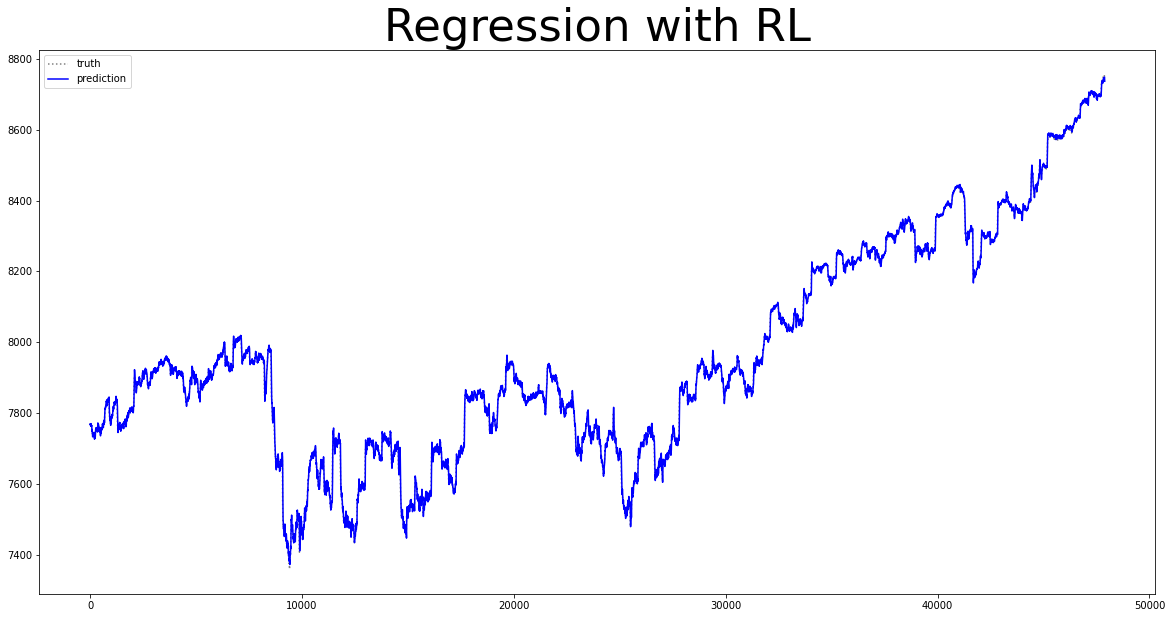

MSE:  78.11669921875
rMSE:  8.83836555480957
MAE:  5.246460914611816
MAPE:  0.000664534221868962


In [21]:
with torch.no_grad():
    model = model.eval()
    test_loss1 = []
    test_loss2 = []
    test_loss3 = []
    test_loss4 = []
    
    answer = []
    prediction = []
    
    for i, (x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device).reshape(-1,1)
        y2 = scaler_close.inverse_transform(y.detach().cpu().numpy())
        answer.extend(y2)
        
        outputs = model(x)
        outputs2 = scaler_close.inverse_transform(outputs.detach().cpu().numpy())
        prediction.extend(outputs2)
        loss = criterion(outputs, y)

        criterion3 = nn.L1Loss()
        loss3 = criterion3(input=outputs, target = y)

        loss4 = torch.mean(torch.abs(torch.subtract(outputs, y) / y))

        test_loss1.append(loss.item())
        test_loss2.append(torch.sqrt(loss).item())
        test_loss3.append(loss3.item())
        test_loss4.append(loss4.item())
        
    print(len(prediction))
                    
            
    plt.figure(figsize=[20,10])
    plt.plot(answer, linestyle=':', color = 'black', alpha = 0.5, label = 'truth')
    plt.plot(prediction, color = 'blue', label = 'prediction')
    plt.legend()
    plt.title("Regression with RL", fontsize=45)
    plt.show()
    
    answer = torch.Tensor(answer)
    prediction = torch.Tensor(prediction)
                
    loss = criterion(answer, prediction)
    criterion3 = nn.L1Loss()
    loss3 = criterion3(input=prediction, target = answer)

    loss4 = torch.mean(torch.abs(torch.subtract(prediction, answer) / answer))

    print("MSE: ", loss.item())
    print("rMSE: ", torch.sqrt(loss).item())
    print("MAE: ", loss3.item())
    print("MAPE: ", loss4.item())

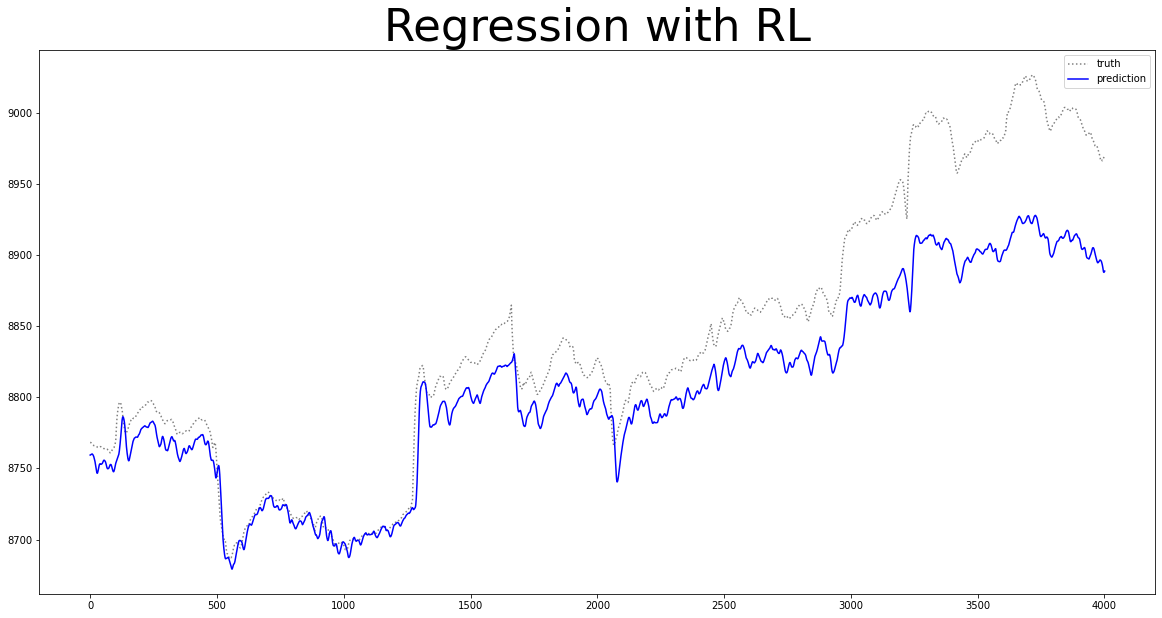

MSE:  2046.69140625
rMSE:  45.24037551879883
MAE:  34.50709915161133
MAPE:  0.003870215732604265


In [18]:
with torch.no_grad():
    model = model.eval()
    test_loss1 = []
    test_loss2 = []
    test_loss3 = []
    test_loss4 = []
    
    answer = []
    prediction = []
    
    for i, (x,y) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device).reshape(-1,1)
        y2 = scaler_close.inverse_transform(y.detach().cpu().numpy())
        answer.extend(y2)
        
        outputs = model(x)
        outputs2 = scaler_close.inverse_transform(outputs.detach().cpu().numpy())
        prediction.extend(outputs2)
        loss = criterion(outputs, y)

        criterion3 = nn.L1Loss()
        loss3 = criterion3(input=outputs, target = y)

        loss4 = torch.mean(torch.abs(torch.subtract(outputs, y) / y))

        test_loss1.append(loss.item())
        test_loss2.append(torch.sqrt(loss).item())
        test_loss3.append(loss3.item())
        test_loss4.append(loss4.item())
                    
            
    plt.figure(figsize=[20,10])
    plt.plot(answer, linestyle=':', color = 'black', alpha = 0.5, label = 'truth')
    plt.plot(prediction, color = 'blue', label = 'prediction')
    plt.legend()
    plt.title("Regression with RL", fontsize=45)
    plt.show()
    
    answer = torch.Tensor(answer)
    prediction = torch.Tensor(prediction)
                
    loss = criterion(answer, prediction)
    criterion3 = nn.L1Loss()
    loss3 = criterion3(input=prediction, target = answer)

    loss4 = torch.mean(torch.abs(torch.subtract(prediction, answer) / answer))

    print("MSE: ", loss.item())
    print("rMSE: ", torch.sqrt(loss).item())
    print("MAE: ", loss3.item())
    print("MAPE: ", loss4.item())

In [19]:
len(prediction)

4002

In [13]:
torch.save({
    'epoch': 350,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optim.state_dict(),
    'loss' : criterion
}, './checkpoint-reg-baseline/lstm.pt')